# Basic Model Training

## Aims
* Using the `compound_rings` data and associated images to train a basic model 
* Perform some error analysis and improve the model 
* Log the results of the experiments as well as the models output ready for deployment

## Notes 
Please read the markdown throughout to continue the MLOps demo.

In [46]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd 
from sklearn.metrics import confusion_matrix, classification_report
import mlflow
import seaborn as sns

## Setup
Any parameters are set up here.

In [4]:
model_version = "v1"
image_size = (300, 300)

In [13]:
experiment_id = mlflow.create_experiment("Predict Compound Rings")

In [17]:
mlflow.end_run()
mlflow.start_run(run_name="v1", experiment_id=experiment_id)

<ActiveRun: >

In [18]:
mlflow.log_param("version", model_version)
mlflow.log_param("image_size", image_size)

## Load Data
Load the csv and build the training data set. 

In [21]:
compound_df = pd.read_csv("data/compound_rings.csv")
display(compound_df)

,compound_id,num_rings,image
0,1117973,5.0,images/1117973.png
1,694811,4.0,images/694811.png
2,1282795,4.0,images/1282795.png
3,1424122,5.0,images/1424122.png
4,1279938,3.0,images/1279938.png
...,...,...,...
95,1524804,3.0,images/1524804.png
96,1524811,3.0,images/1524811.png
97,1442535,3.0,images/1442535.png
98,1442562,3.0,images/1442562.png


In [22]:
compound_image_data = []
compound_ring_cats = []
compound_ring_labels = []
for row in compound_df.iterrows():
    compound_image_data.append(plt.imread(row[1]["image"]))
    compound_ring_labels.append(int(row[1]["num_rings"]))
    compound_ring_cats.append(int(row[1]["num_rings"]) - 1)

compound_image_data = np.array(compound_image_data)
compound_ring_cats = np.array(compound_ring_cats)

Split the data in to a training set and a validation set which will only be used the validate the final model.

In [23]:
x_train, x_test, y_train, y_test = train_test_split(compound_image_data, compound_ring_cats, test_size=0.25, random_state=42)

Visualise the data.

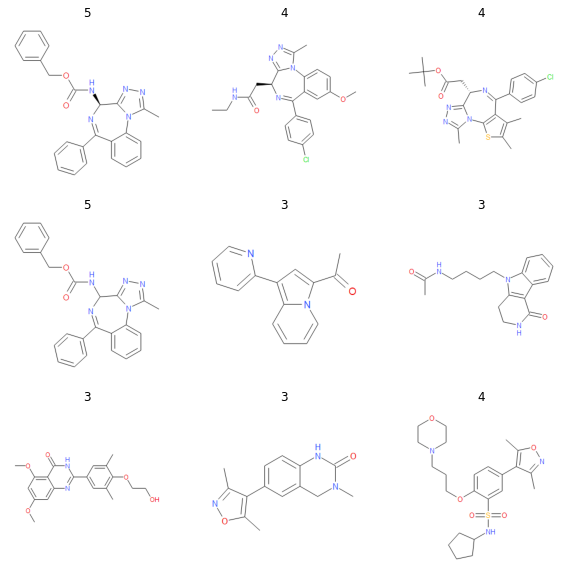

In [24]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(compound_image_data[i])
    plt.title(compound_ring_labels[i])
    plt.axis("off")

We can also inspect the shape of the data to help build our model.

In [25]:
x_train.shape, y_train.shape

((75, 300, 300, 3), (75,))

In [26]:
x_test.shape, y_test.shape

((25, 300, 300, 3), (25,))

In [27]:
mlflow.log_param("training_samples", y_train.shape[0])
mlflow.log_param("holdout_samples", y_test.shape[0])

We have 75 training and 25 test samples, the images are 300 x 300 pixels and have 3 layers.

Let's build and train a demo model.

In [28]:
model = keras.Sequential(
    [
        keras.Input(shape=image_size + (3,)),
        # conv layers 
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5), # Dropout to help reduce overfitting
        layers.Dense(5, activation="softmax"), # 5 output classes 
    ]
)

2021-09-18 17:56:55.519744: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-18 17:56:55.519792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-18 17:56:55.519817: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2e6e3127db37): /proc/driver/nvidia/version does not exist
2021-09-18 17:56:55.520019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
val_split = 0.2
batch_size = 12
epochs = 15

In [30]:
mlflow.log_param("val_split", val_split)
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)

In [31]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, keras.utils.to_categorical(y_train, num_classes=5), batch_size=batch_size, epochs=epochs, validation_split=0.2)

2021-09-18 17:57:42.116871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
5/5 [==============================] - 3s 564ms/step - loss: 13.4229 - accuracy: 0.2833 - val_loss: 6.0734 - val_accuracy: 0.0667
Epoch 2/15
5/5 [==============================] - 3s 535ms/step - loss: 2.4644 - accuracy: 0.2667 - val_loss: 1.7072 - val_accuracy: 0.2000
Epoch 3/15
5/5 [==============================] - 3s 649ms/step - loss: 1.4927 - accuracy: 0.3333 - val_loss: 1.3860 - val_accuracy: 0.2000
Epoch 4/15
5/5 [==============================] - 3s 497ms/step - loss: 1.3426 - accuracy: 0.4000 - val_loss: 1.3671 - val_accuracy: 0.4000
Epoch 5/15
5/5 [==============================] - 2s 472ms/step - loss: 1.1847 - accuracy: 0.6000 - val_loss: 1.6107 - val_accuracy: 0.2667
Epoch 6/15
5/5 [==============================] - 3s 517ms/step - loss: 1.0824 - accuracy: 0.5333 - val_loss: 1.3494 - val_accuracy: 0.2667
Epoch 7/15
5/5 [==============================] - 2s 503ms/step - loss: 0.8505 - accuracy: 0.7167 - val_loss: 1.4101 - val_accuracy: 0.5333
Epoch 8/15
5/5 [===

Additional callbacks could be used to track more suitable metrics for analysis. For this MLOps example, let's keep it basic (it's just a demo!). We can make some plots with the data we have collected and track in MLFlow.

In [33]:
training_df = pd.DataFrame(model.history.history)

In [44]:
for row in training_df.iterrows():
    mlflow.log_metric("loss", row[1]["loss"])
    mlflow.log_metric("val_loss", row[1]["val_loss"])
    mlflow.log_metric("accuracy", row[1]["accuracy"])
    mlflow.log_metric("val_accuracy", row[1]["val_accuracy"])

In [38]:
for loss in training_df["loss"]:
    mlflow.log_metric("loss", loss)

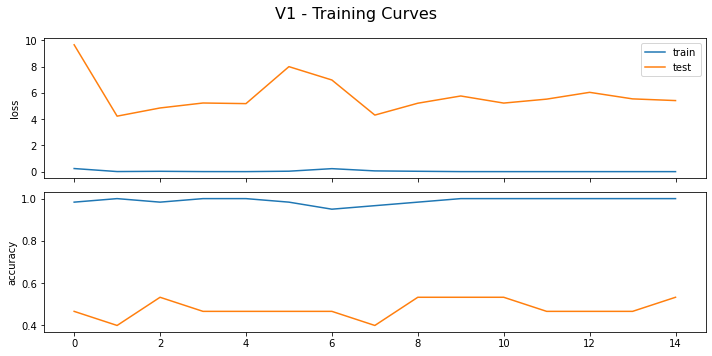

In [149]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 5))

sns.lineplot(data=training_df, x=training_df.index, y="loss", label="train", ax=ax1)
sns.lineplot(data=training_df, x=training_df.index, y="val_loss", label="test", ax=ax1)

sns.lineplot(data=training_df, x=training_df.index, y="accuracy", ax=ax2)
sns.lineplot(data=training_df, x=training_df.index, y="val_accuracy", ax=ax2)

plt.suptitle("V1 - Training Curves", fontsize=16)
plt.tight_layout()
plt.show()

Let's make some predictions from the holdout set and see the "real world" performance of our model.

In [48]:
y_pred = model.predict(x_test)
y_pred_train = model.predict(x_train)

A confusion matrix is useful for classification tasks.

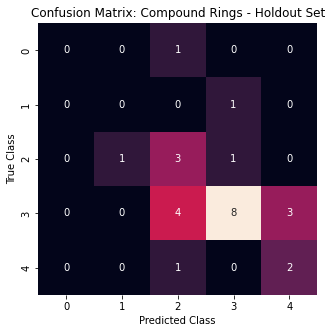

In [54]:
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
plt.figure(figsize=(5, 5))
sns.heatmap(matrix, annot=True, cbar=False)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix: Compound Rings - Holdout Set")
plt.show()

In [103]:
clf_rep = classification_report(y_test, y_pred.argmax(axis=1))
print(clf_rep)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.38      0.60      0.46         5
           3       0.83      0.67      0.74        15
           4       0.50      0.67      0.57         3

    accuracy                           0.60        25
   macro avg       0.34      0.39      0.35        25
weighted avg       0.64      0.60      0.61        25



/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


On the validation set the model seems to be overfit to predicting class 3 (4 rings). As this is a toy example I won't continue with much analysis. Some initial observations;

* (below) we can see the training data output, there is 0 support for class 0 and only 9 for class 1 - more data is required (this would likely have been called out in the scoping phase), never the less we have a benchmark which is better than random
* Class 3 has the highest support and like in the validation set performs well
* In the real world, as well as iterating on data we could look to iterate and improve the model.

In [69]:
print(classification_report(y_train, model.predict(x_train).argmax(axis=1)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       0.88      1.00      0.94        22
           3       0.86      0.96      0.91        26
           4       0.92      0.61      0.73        18

    accuracy                           0.89        75
   macro avg       0.91      0.89      0.89        75
weighted avg       0.90      0.89      0.89        75



This model isn't great, it is overfit to the train set, but for now let's try and deploy it. We can come back later and improve the model.

In [57]:
mlflow.keras.save_model(model, f"models/{model_version}")

2021-09-18 18:08:15.955549: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/jovyan/data-science/models/v1/data/model/assets


In [155]:
mlflow.end_run()